In [117]:
# Module with plot capabilities
import matplotlib.pyplot as plt
import seaborn as sns
import hyperspy.api as hs

# Module with scientific computing functions (matrix/vector)
import numpy as np                

# Modules with reading/write folder/file functions
import os
from pathlib import Path
import SimpleITK as sitk

# module to deal with images
import uproot
#%pip install SciencePlots
import scienceplots
from scipy.ndimage import gaussian_filter1d

plt.style.use(['science', 'ieee'])  

# The following command display the current working directory (where jupyter has been launched)
cwd = os.getcwd()
print('The Current Working Directory (CWD) is: \n', cwd)
folder = Path()

# Display the content of a folder
output_folder = Path('./output')
if not output_folder.is_dir():
    print('ERROR: {} is not a folder.'.format(output_folder))
else:
    print('The folder and contains the following files:'.format(output_folder))
    p = output_folder.glob('**/*')
    files = [x for x in p if x.is_file()]
    for x in files:
        print(x)

The Current Working Directory (CWD) is: 
 /home/francesco/gate/VHEE_monitor
The folder and contains the following files:
output/dose3d_120_dose.mhd
output/Hits.root
output/dose3d_120_edep.raw
output/dose3d_120_dose.raw
output/dose3d_120_dose_uncertainty.raw
output/photondata.root
output/dose3d_120_dose_uncertainty.mhd
output/stats.txt
output/photonhits.root
output/Singles.root
output/dose3d_120_edep.mhd


Dose itk image size:  (24, 24, 240)
Dose itk image spacing:  (5.0, 5.0, 5.0)
Dose itk image origin:  (-57.5, -57.5, -597.5)
Dose np image size =  (240, 24, 24)
Dose np image min and max:  0.0 0.0001065181959093587
Dose np image min and max:  0.0 100.0
(240, 24, 24)


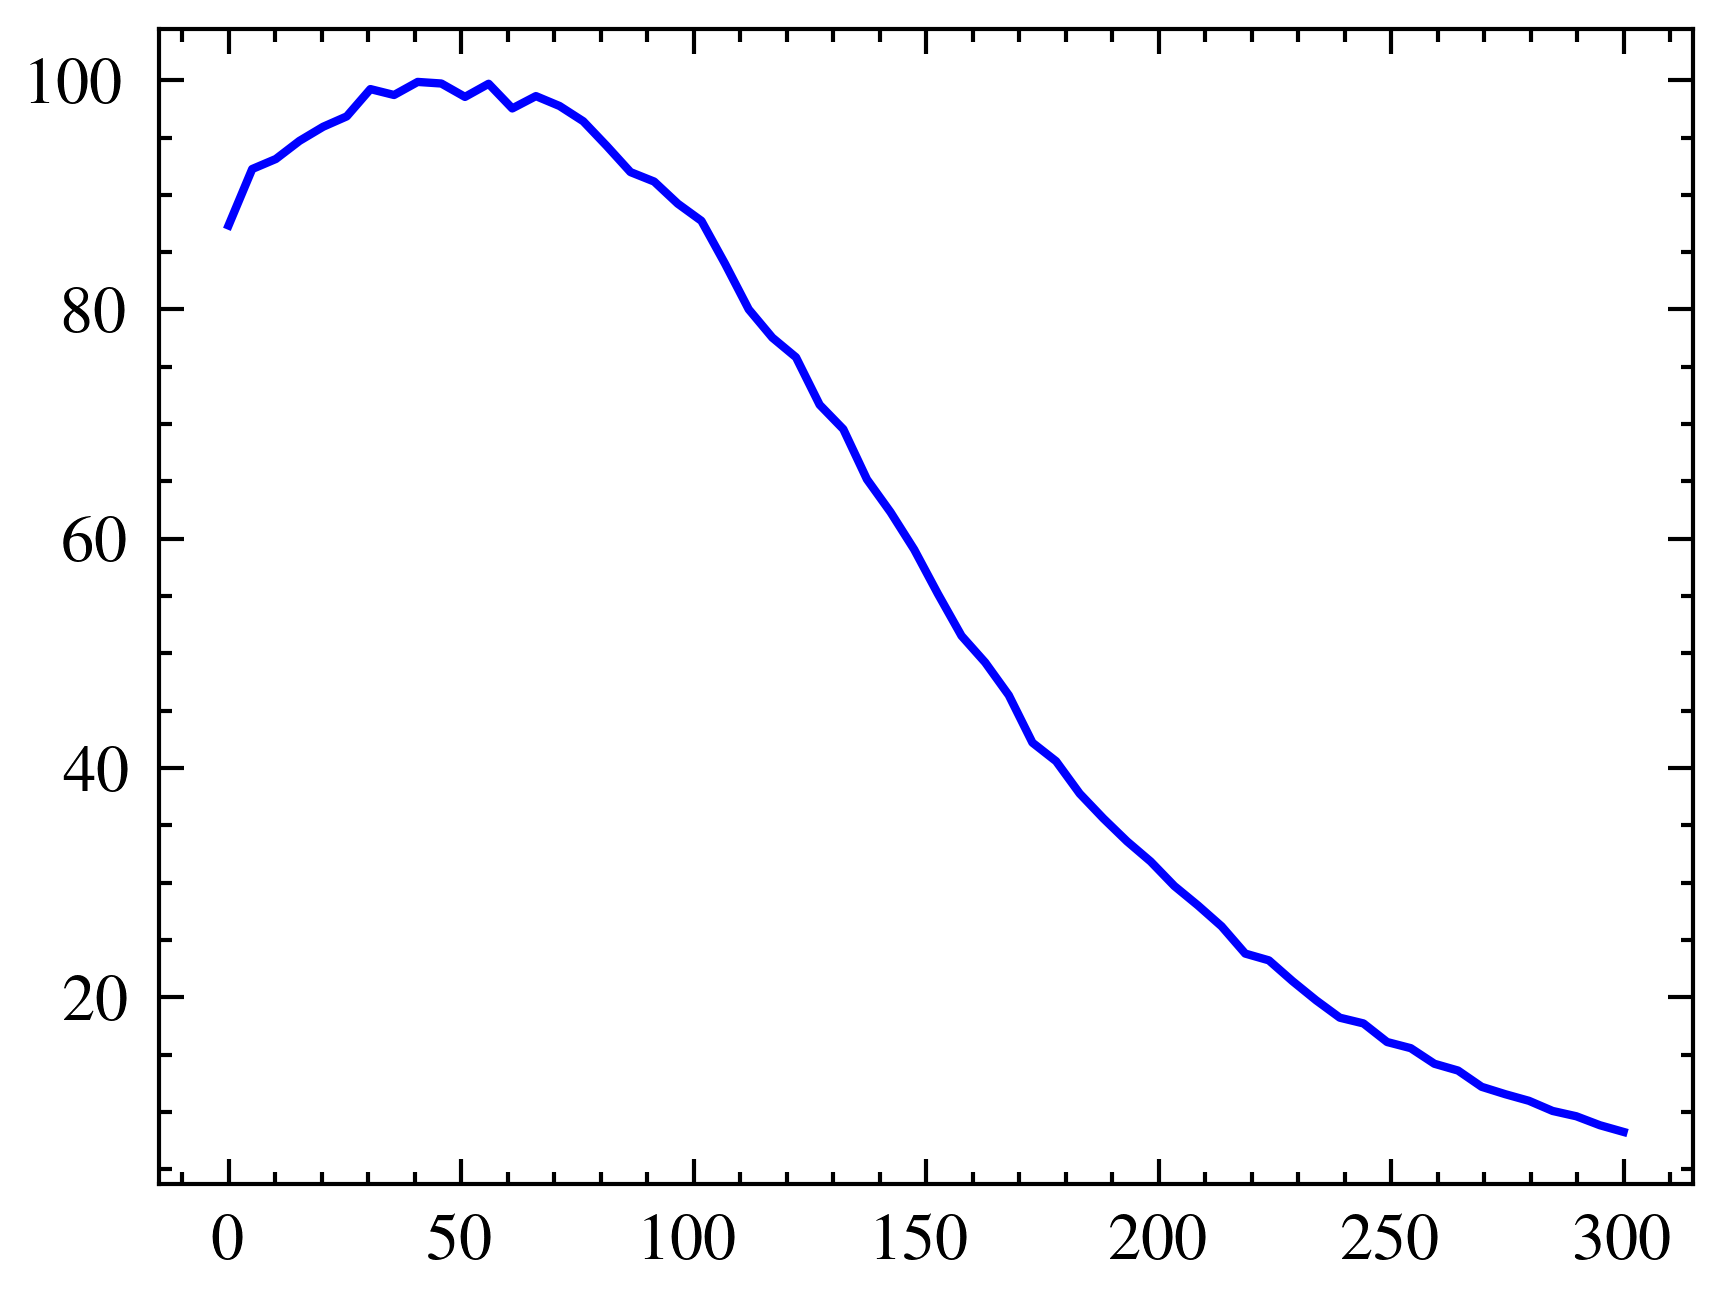

In [186]:

filename = os.path.join(folder, 'output/dose3d_120_dose.mhd')
img_dose = sitk.ReadImage(filename)
print('Dose itk image size: ', img_dose.GetSize())
print('Dose itk image spacing: ', img_dose.GetSpacing())
print('Dose itk image origin: ', img_dose.GetOrigin())
# convert to np array for easier manipulation
# WARNING : the axis are modified, XYZ -> ZXY
arr_dose = sitk.GetArrayFromImage(img_dose)
#get normal axes
print('Dose np image size = ', arr_dose.shape)
print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

# multiply the image because to avoid rounding issues
#filter = sitk.MultiplyImageFilter()
#img_dose = filter.Execute(img_dose, 1e9)
#arr_dose = sitk.GetArrayFromImage(img_dose)
#print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))
# now we rescale the intensity between 0 and 1 (normalization)
filter = sitk.RescaleIntensityImageFilter()
filter.SetOutputMaximum(100.0)
filter.SetOutputMinimum(0.0)
img_dose = filter.Execute(img_dose)
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))
# Declare a figure
fig3, ax3 = plt.subplots()
np.shape(arr_dose[1])
# mean the dose along a given dimension (depth)
moy_dose=np.zeros(arr_dose.shape[0])
for i in range(arr_dose.shape[0]):
    subarr_dose=arr_dose[i,:,:]
    moy_dose[i]=np.sum(subarr_dose)

# X values from 0 to n
# n is the number of slices
n = arr_dose.shape[0]
x = np.linspace(0, 300, 60)

#c1 = ax3.plot(x, moy_dose, label='deposited dose', linewidth=1, markersize=2, color='red')
## Add labels to the axes
#ax3.set_xlabel('Depth (mm)')
#ax3.set_ylabel('Dose (Gy)')


# Add legends to the plot
#ax3.legend(loc='upper right')
#plt.show()

print(arr_dose.shape)
plt.plot(x, arr_dose[90:150,12,12], label='deposited dose', linewidth=1, markersize=2, color='blue')
# Add labels to the axes
plt.show()


In [119]:
f = uproot.open('C11/c11hits.root')
print("List of tree : \n", f.keys())
hits = f['Singles']
print('Number of hits:', hits.num_entries)
print('Hits keys: ')
for i in hits.keys():
    print(i, ' ', end='')

List of tree : 
 ['Singles;1']
Number of hits: 8290.0
Hits keys: 
PostPosition_X  PostPosition_Y  PostPosition_Z  PreKineticEnergy  TotalEnergyDeposit  PreDirection_X  PreDirection_Y  PreDirection_Z  PreStepUniqueVolumeID  GlobalTime  

In [120]:
hits_y = np.array(hits.arrays()['PostPosition_Y'])
hits_z = np.array(hits.arrays()['PostPosition_Z'])
hits_x = np.array(hits.arrays()['PostPosition_X'])
preKinEnergy = np.array(hits.arrays()['PreKineticEnergy'])  

#preKinEnergy_enwin = np.logical_and(preKinEnergy > 15)#, preKinEnergy < 2)

masky=np.logical_and(hits_y > -3, hits_y < 3)
hits_y_enwin = hits_y[preKinEnergy>15]
hits_z_enwin = hits_z[preKinEnergy>15]


plt.figure(figsize=(10, 3))

#plt.scatter(x=hits_z, y=hits_y)

#plt.title('Scatter Plot of Hits')
#plt.show()







<Figure size 6000x1800 with 0 Axes>

<Figure size 6000x1800 with 0 Axes>

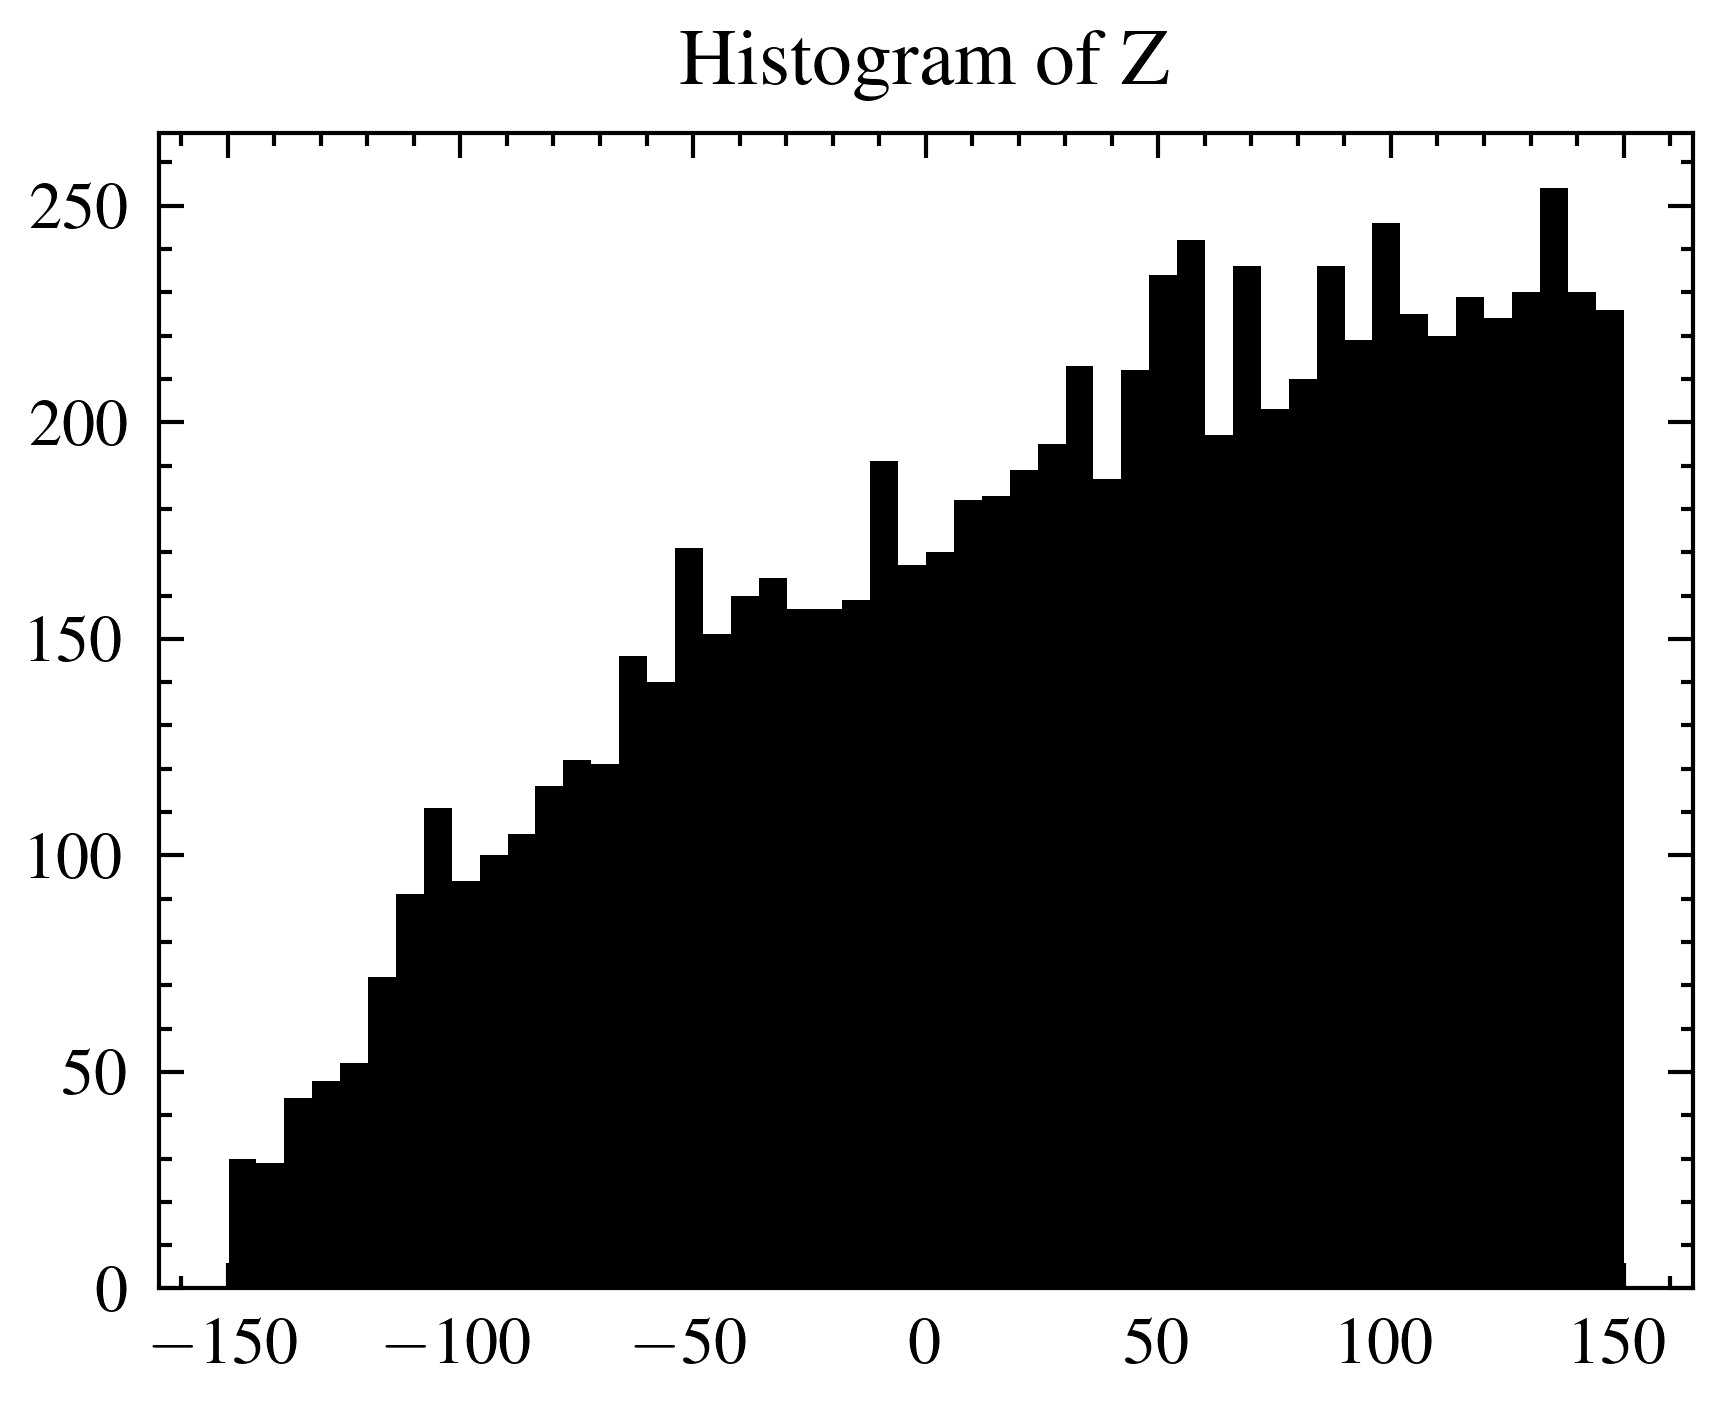

In [121]:
plt.hist(hits_z, bins=50)
plt.title('Histogram of Z')
plt.show()




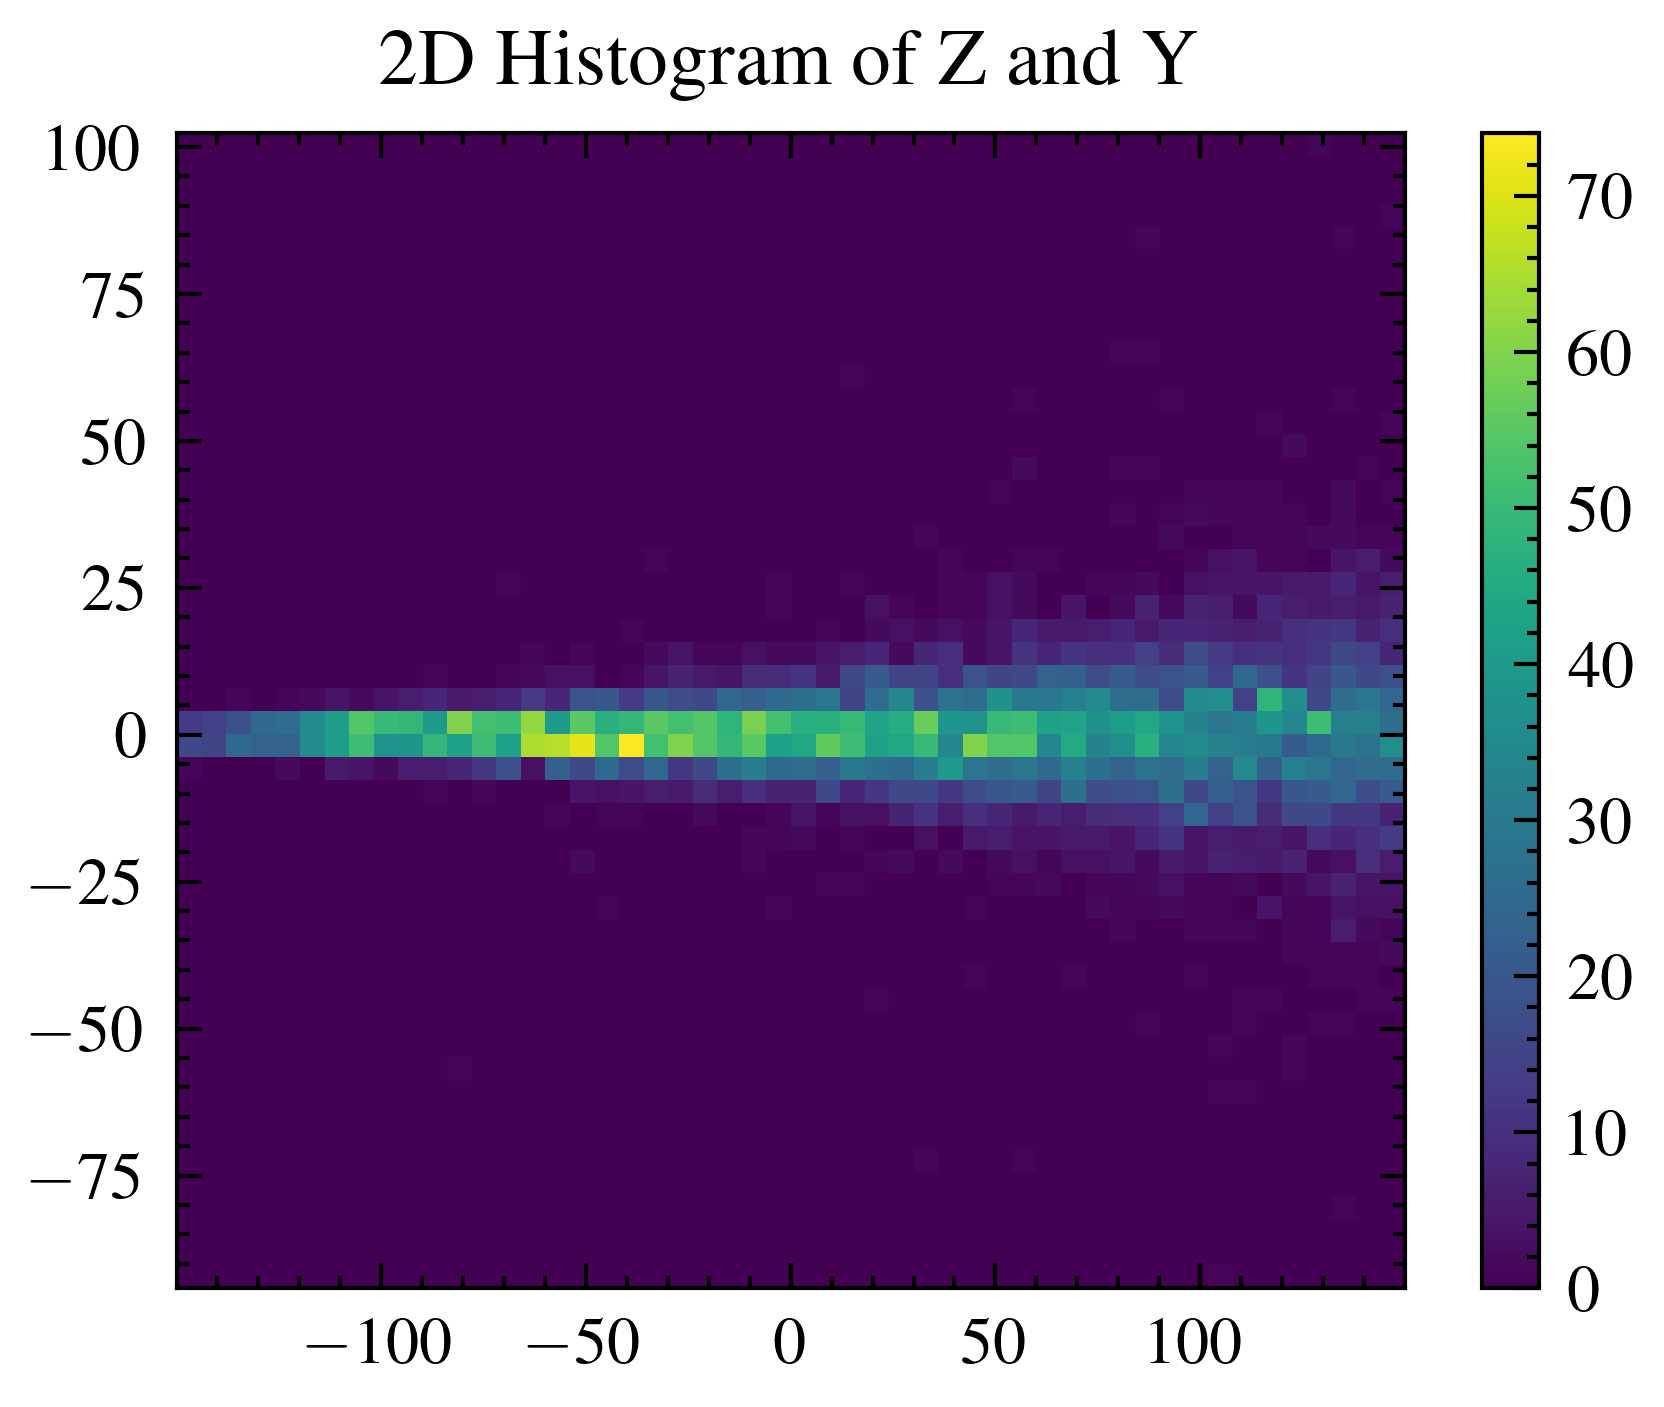

/tmp/ipykernel_1034254/3450230030.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1034254/3450230030.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='upper right')


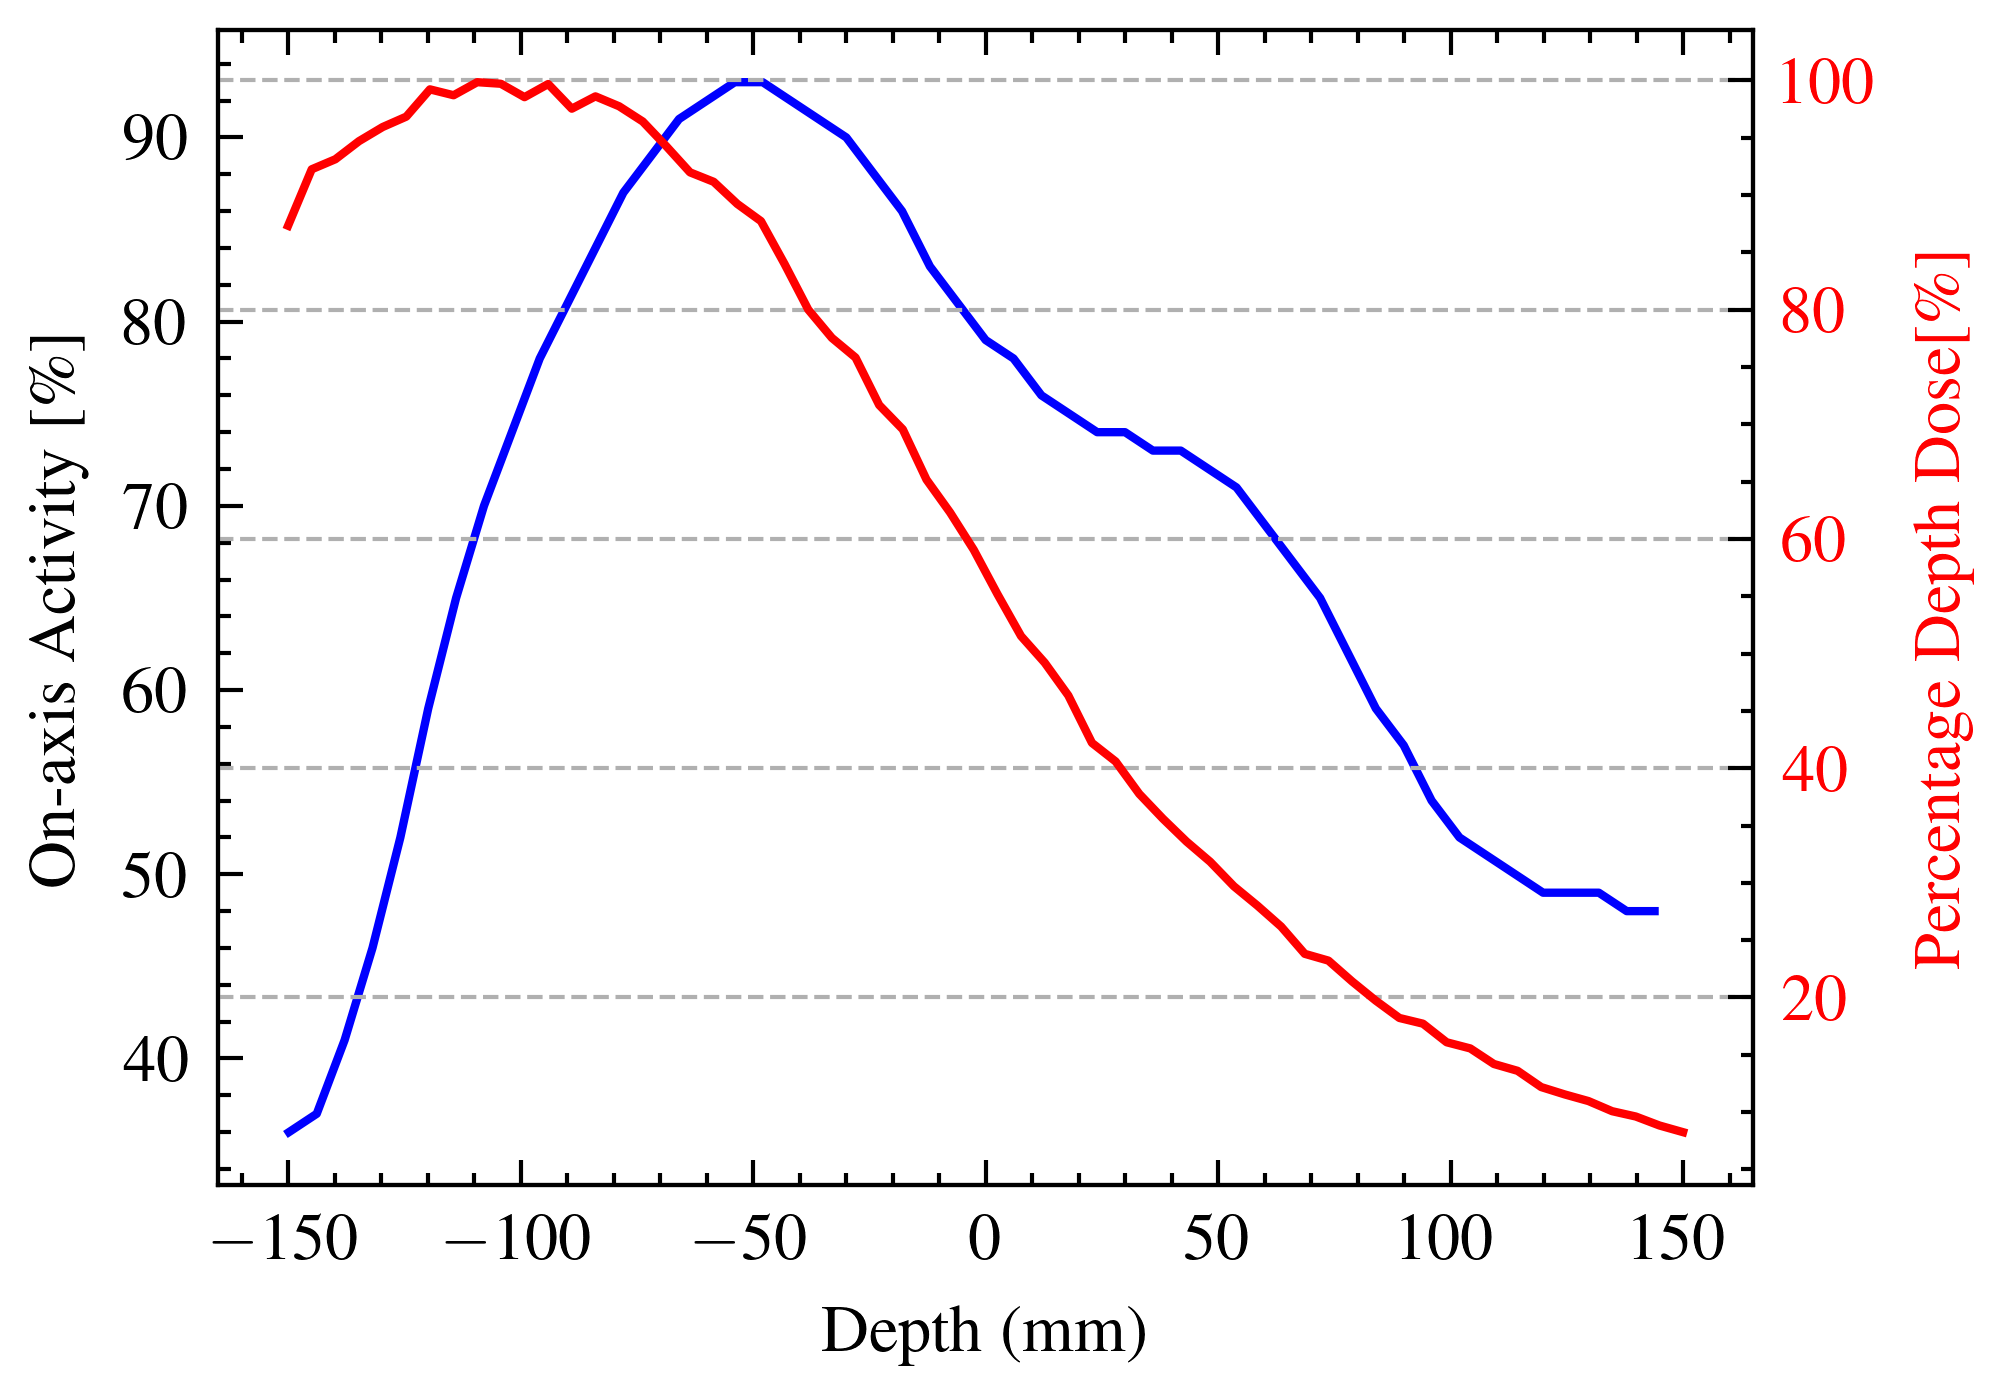

In [189]:
plt.hist2d(hits_z, hits_y, bins=50) 
plt.colorbar()
plt.title('2D Histogram of Z and Y')
plt.show()
# Central axis profile#
masky=np.logical_and(hits_y > -3, hits_y < 3)

hits_z_central=hits_z[masky]
# Smooth the histogram using a Gaussian filter

hist, bin_edges = np.histogram(hits_z_central, bins=50)
hist_smoothed = gaussian_filter1d(hist, sigma=3)
fig3, ax3 = plt.subplots()

# Plot the smoothed histogram hist_smoothed*0.034

plt.plot(bin_edges[:-1], hist_smoothed, color='blue')
plt.xlabel('Z (mm)')
plt.ylabel('On-axis Activity [\%]')
plt.legend()

# Add a secondary y-axis for the scale on the right
ax3_secondary = ax3.twinx()
ax3_secondary.plot(x - 150, arr_dose[90:150,12,12], label='deposited dose', linewidth=1, markersize=2, color='red')
ax3_secondary.set_ylabel('Percentage Depth Dose[\%]', color='red')
ax3_secondary.tick_params(axis='y', labelcolor='red')
ax3.set_xlabel('Depth (mm)')

plt.grid(axis='both', linestyle='--', linewidth=0.5) 
# Add legends to the plot
ax3.legend(loc='upper right')
plt.show()

In [ ]:
# Define the bin edges
bins = [np.linspace(hits_y.min(), hits_y.max(), 150), np.linspace(hits_z.min(), hits_z.max(), 150)]

# Create a 2D histogram
hist, yedges, xedges = np.histogram2d(hits_y, hits_z, bins=bins)

# Extend each bin in a Gaussian way
ycenters = (yedges[:-1] + yedges[1:]) / 2
xcenters = (xedges[:-1] + xedges[1:]) / 2
y, x = np.meshgrid(ycenters, xcenters)

# Create a Gaussian kernel
sigma = 1.0
gaussian_kernel = np.exp(-((y[:, :, np.newaxis, np.newaxis] - ycenters[np.newaxis, np.newaxis, :, np.newaxis])**2 +
                           (x[:, :, np.newaxis, np.newaxis] - xcenters[np.newaxis, np.newaxis, np.newaxis, :])**2) / (2 * sigma**2))

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum(axis=(2, 3))

# Convolve the histogram with the Gaussian kernel
hist_smoothed = np.tensordot(hist, gaussian_kernel, axes=([0, 1], [2, 3]))



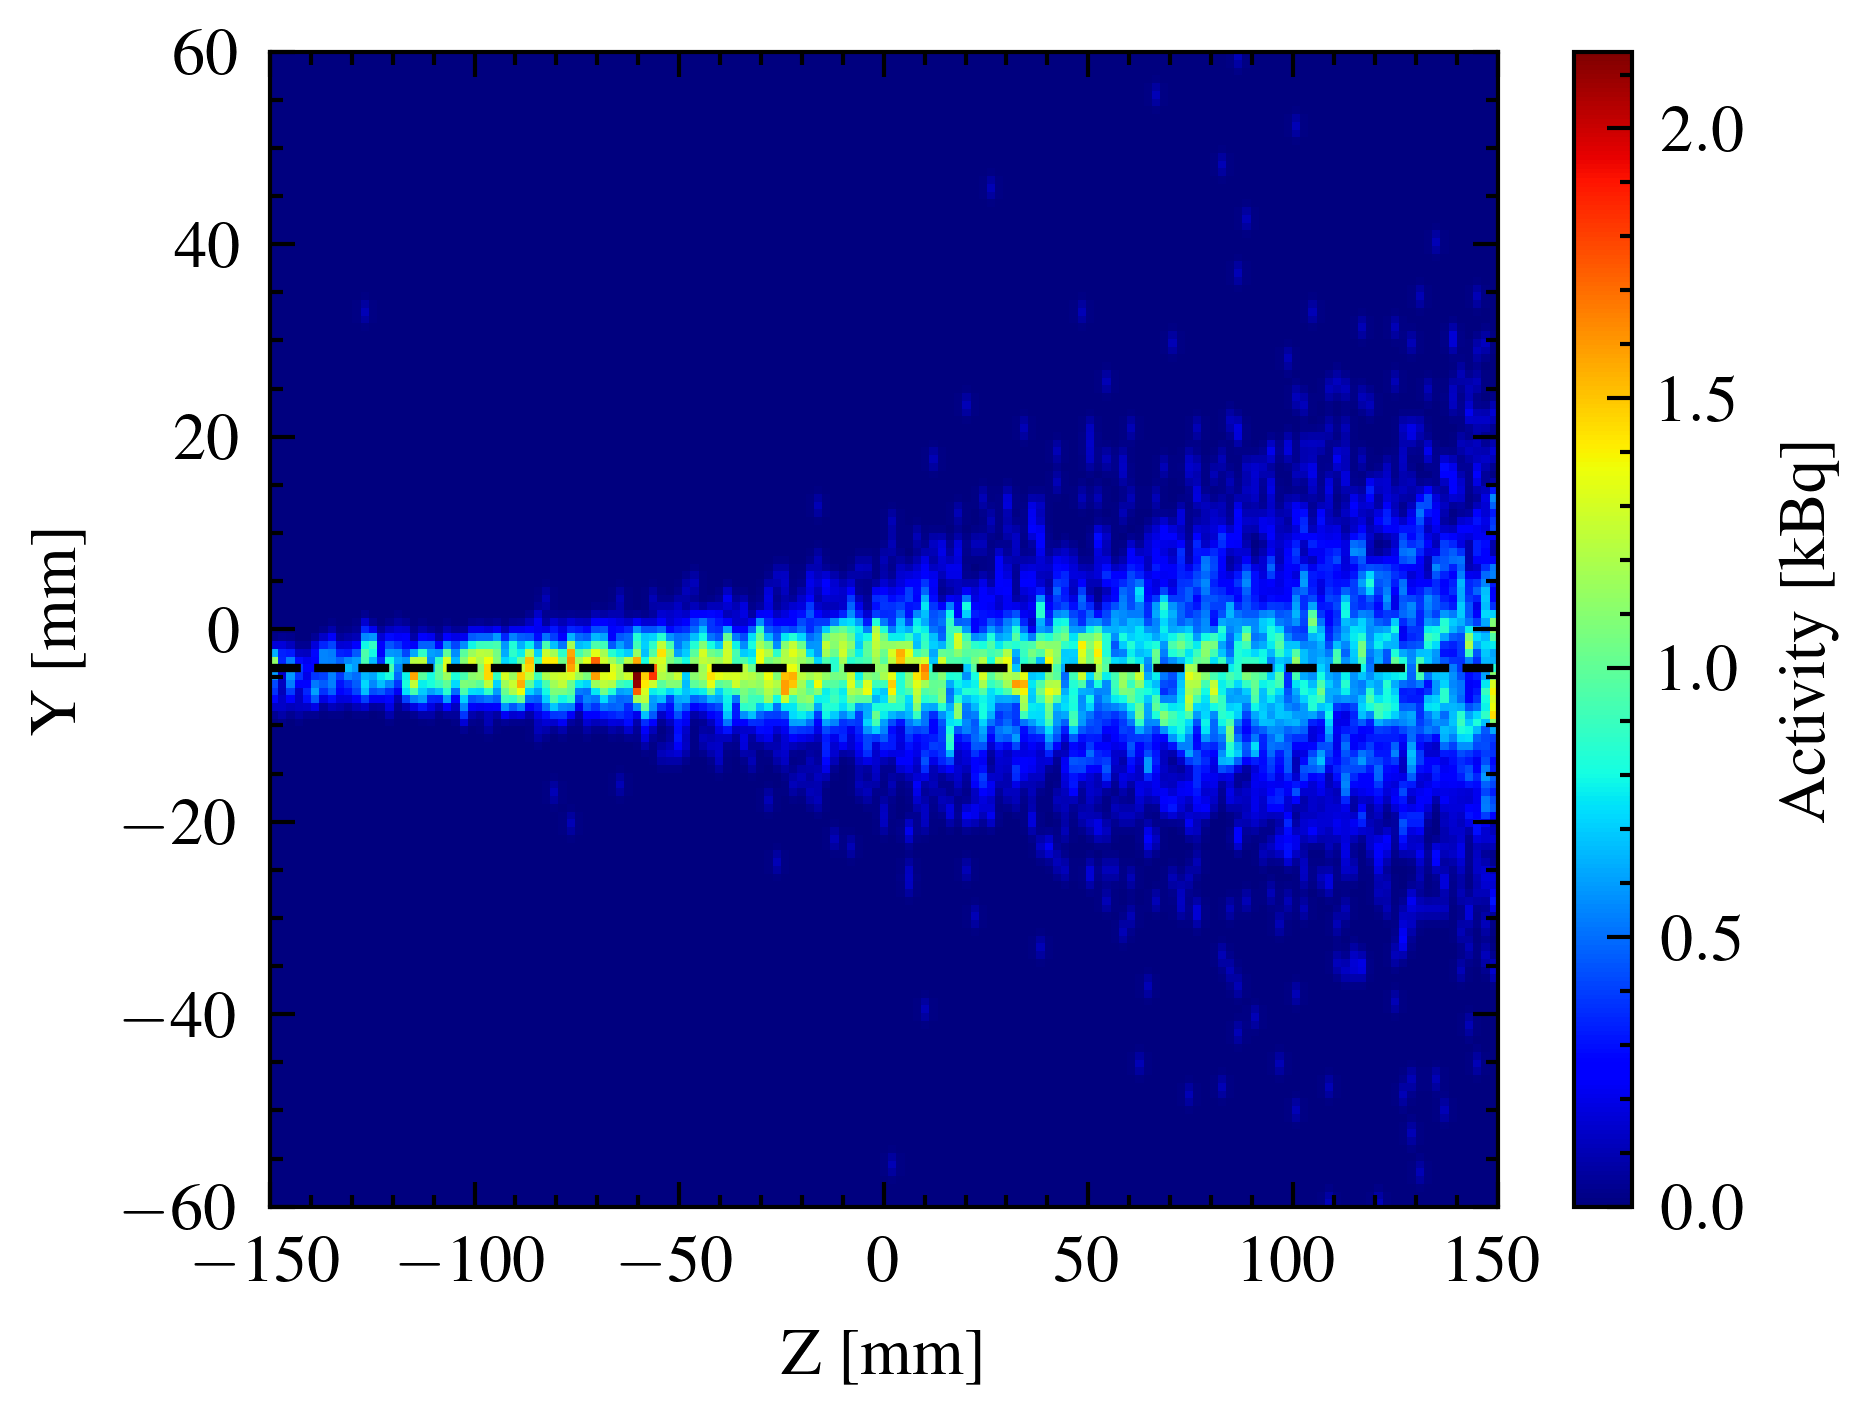

In [ ]:
# Plot the smoothed 2D histogram
hist_smoothed1 = (hist_smoothed *0.34) #kBq per 10^11
plt.imshow(hist_smoothed1.T, origin='lower', aspect='auto', cmap='jet', extent=(-150, 150,-60, 60))
plt.axhline(y=-4, color='black', linestyle='--')
plt.colorbar(label='Activity [kBq]')
plt.xlabel('Z [mm]')
plt.ylabel('Y [mm]')
plt.show()

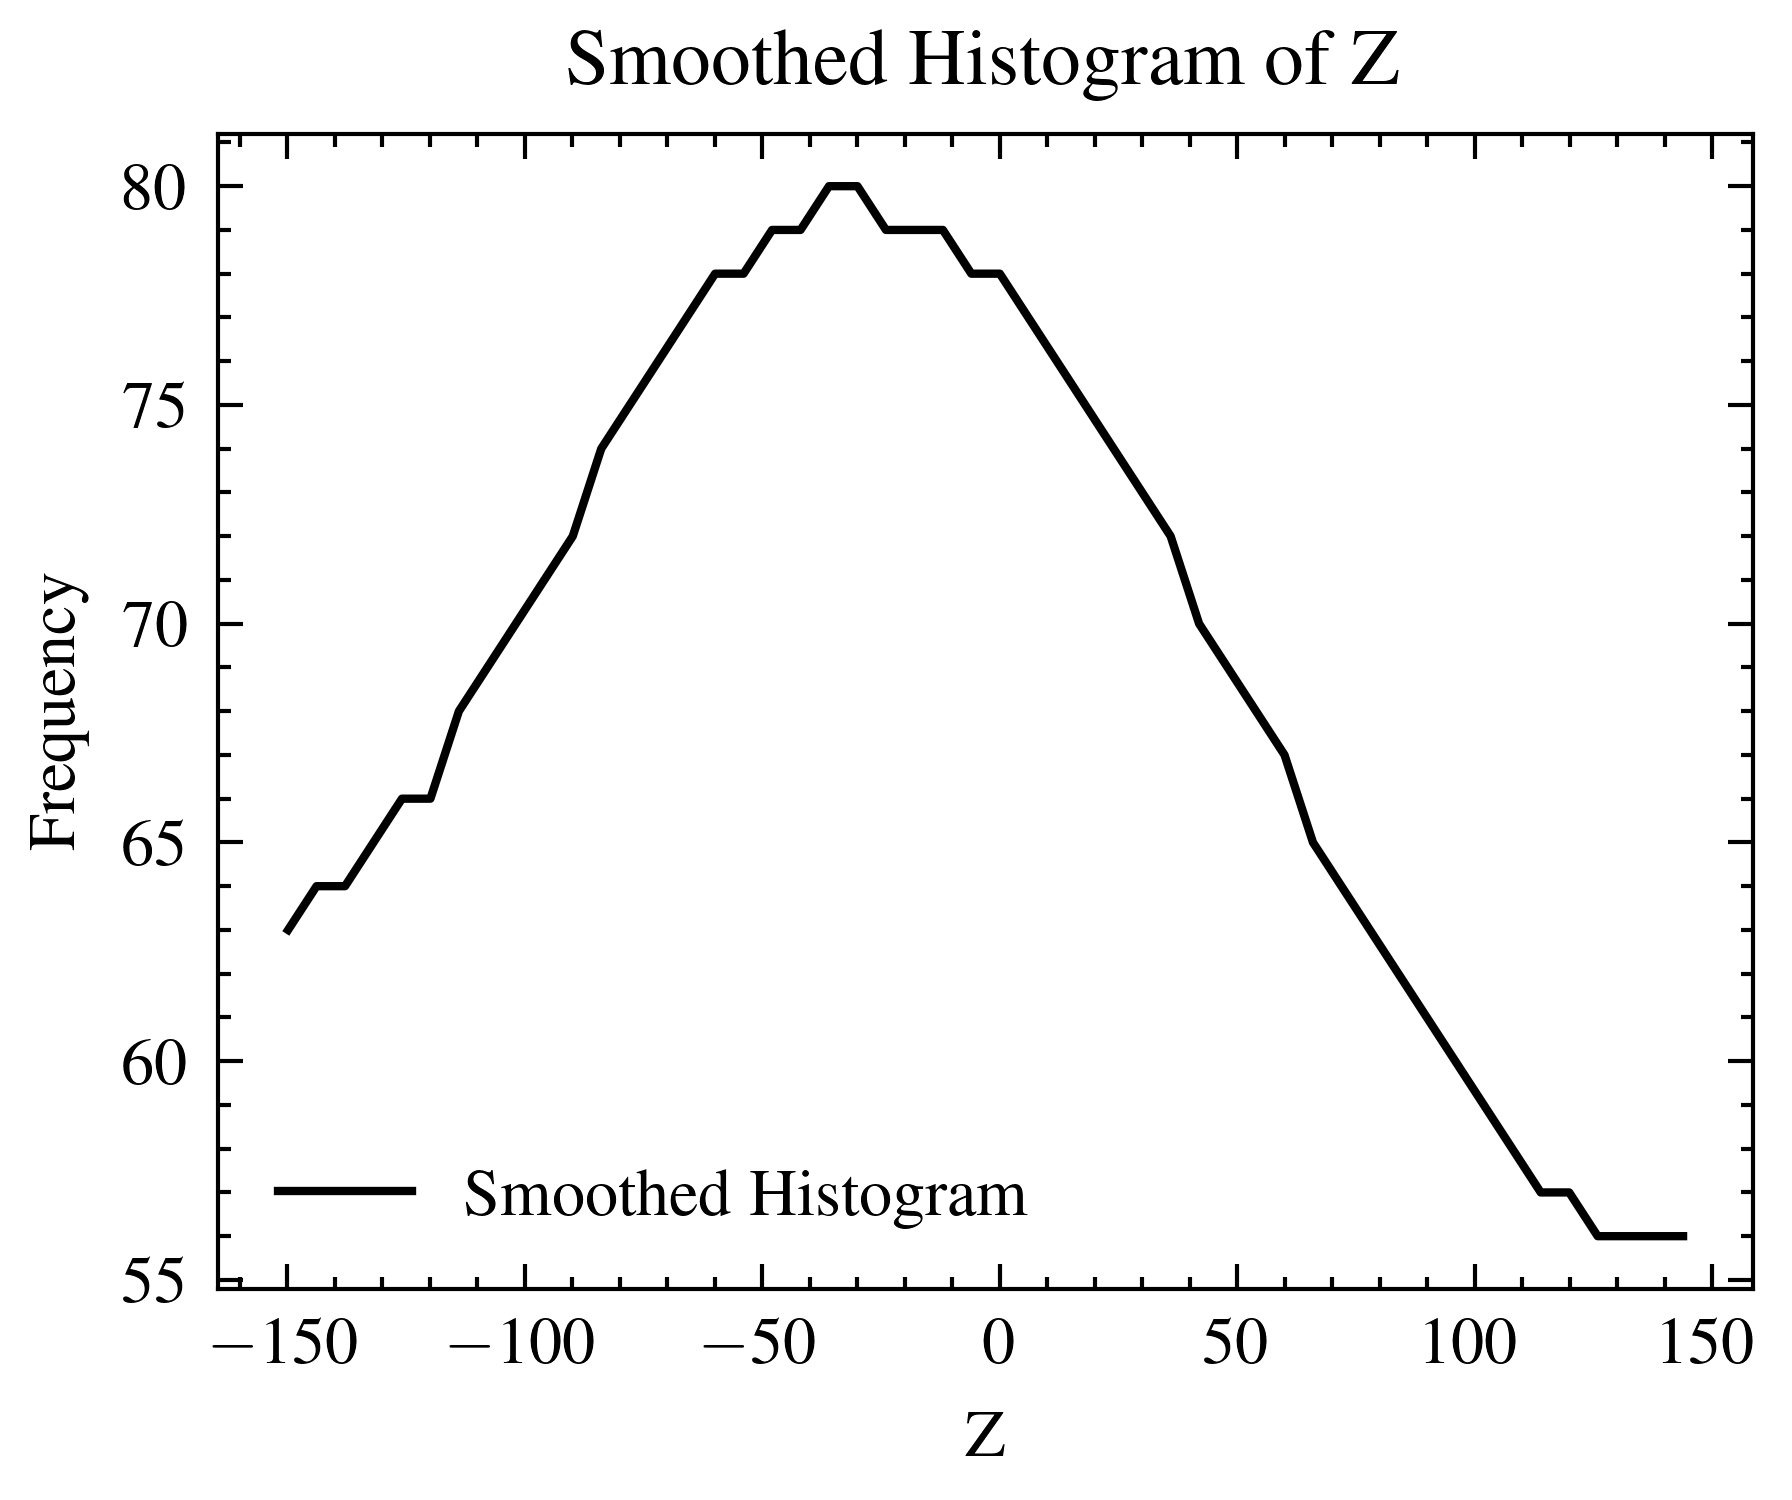

In [ ]:

masky=np.logical_and(hits_y > -3, hits_y < 3)

hits_z_central=hits_z[masky]
# Smooth the histogram using a Gaussian filter

hist, bin_edges = np.histogram(hits_z_central, bins=50)
hist_smoothed = gaussian_filter1d(hist, sigma=10)

# Plot the smoothed histogram
plt.plot(bin_edges[:-1], hist_smoothed, label='Smoothed Histogram')
plt.title('Smoothed Histogram of Z')
plt.xlabel('Z')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Number of coupled hits: 354
354


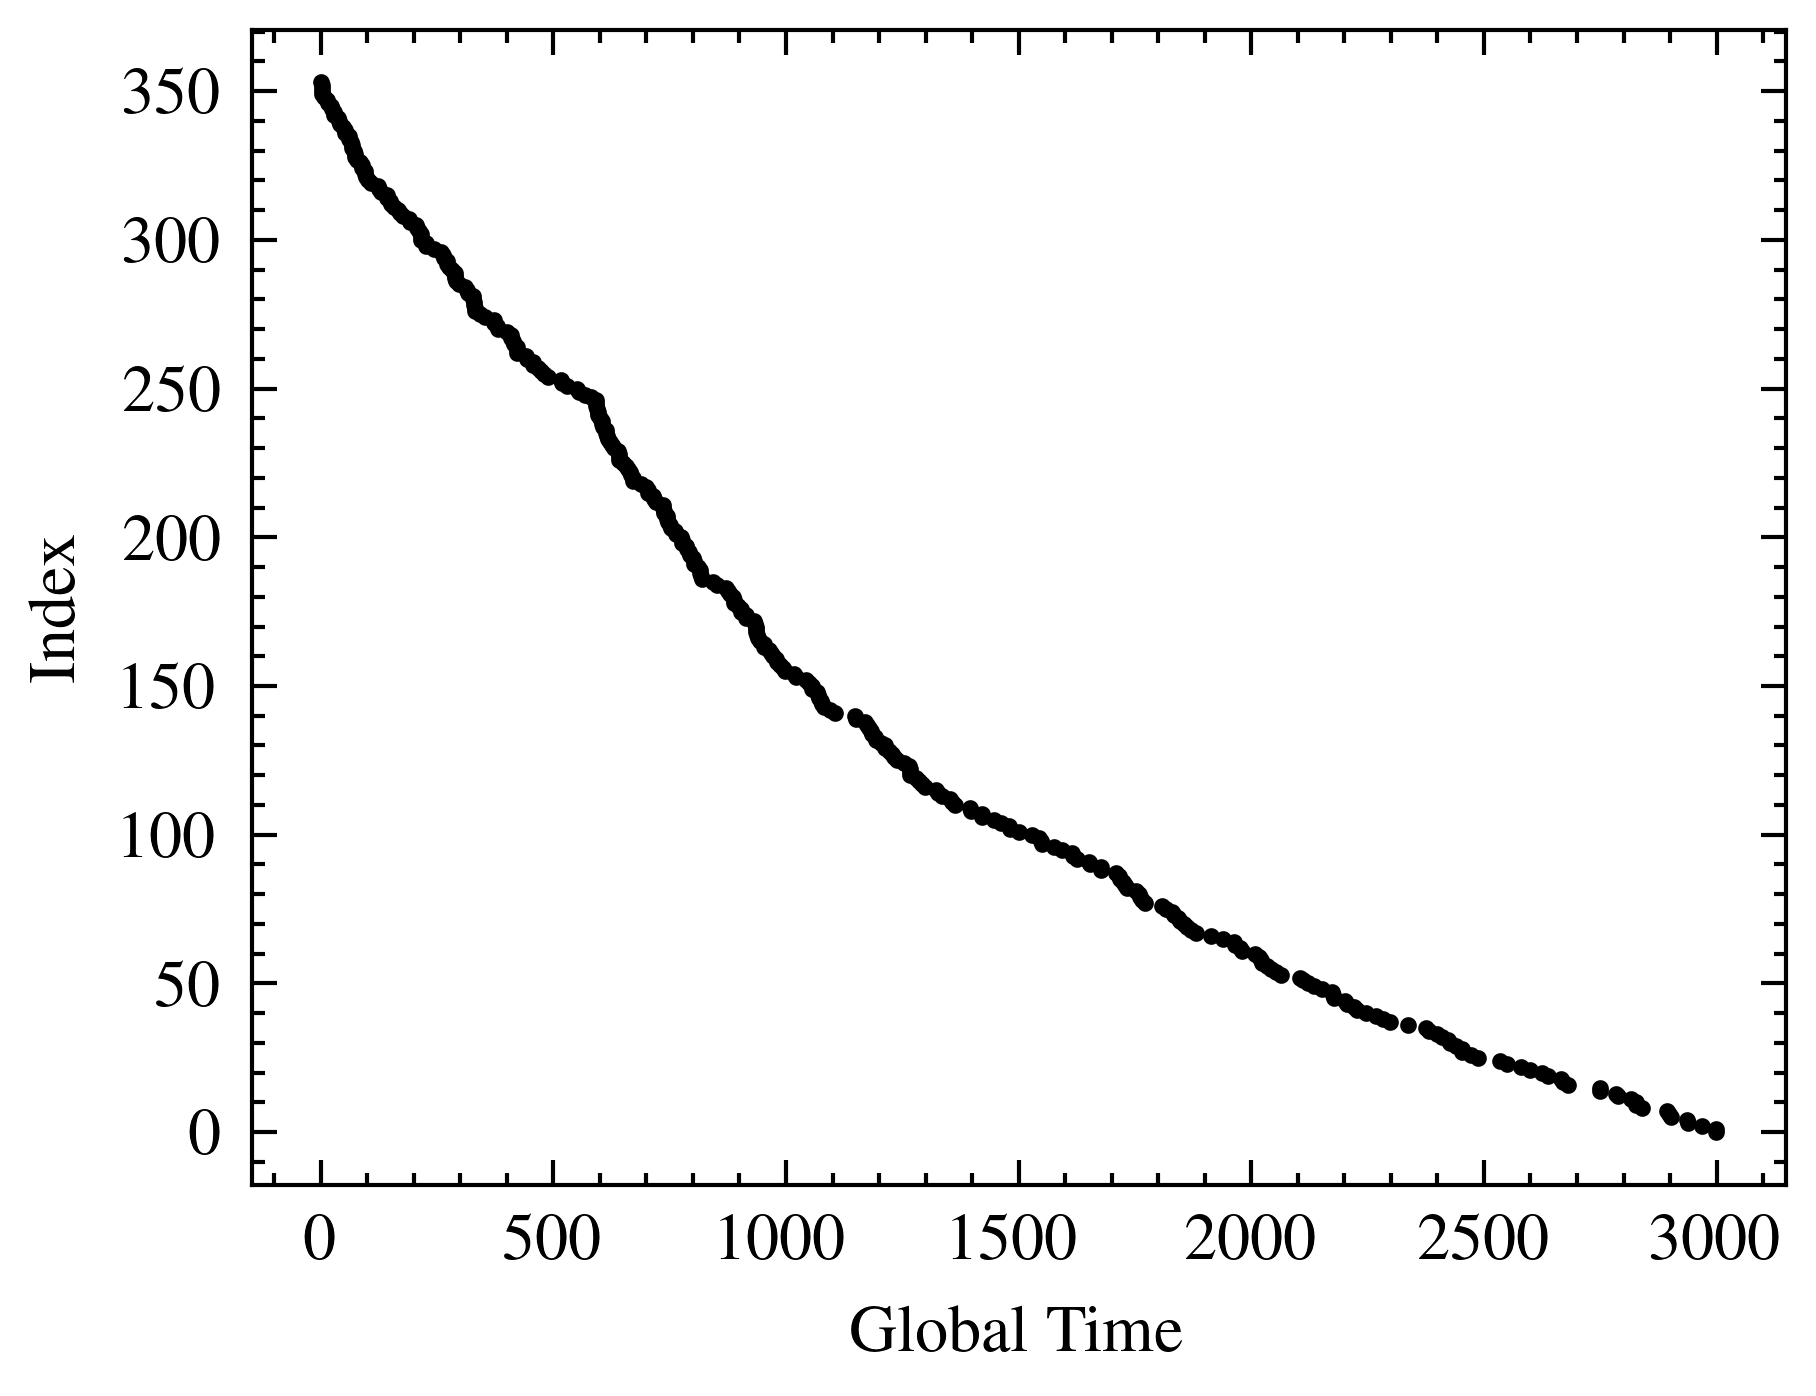

In [ ]:
f=uproot.open('output/Singles.root')
f.keys()
hits = f['Singles']
hits.keys()
hits_y = np.array(hits.arrays()['PostPosition_Y'])
hits_z = np.array(hits.arrays()['PostPosition_Z'])
hits_x = np.array(hits.arrays()['PostPosition_X'])
t= np.array(hits.arrays()['GlobalTime'])

#plt.hist(t, bins=50)

arrival_window = 2  #globatime is in nanoseconds

# Find the indices of hits that are within the arrival window
coupled_hits_indices = np.where(np.diff(t) < arrival_window)[0]

# Extract the coupled hits
coupled_hits_y = hits_y[coupled_hits_indices]
coupled_hits_z = hits_z[coupled_hits_indices]
coupled_hits_x = hits_x[coupled_hits_indices]

print('Number of coupled hits:', len(coupled_hits_indices))
print(len(t[coupled_hits_indices]))
coupled_hits_indices = coupled_hits_indices[::-1]

time=t[coupled_hits_indices]*1e-9
coinc_counts = np.arange(len(coupled_hits_indices))

plt.scatter(t[coupled_hits_indices]*1e-9, np.arange(len(coupled_hits_indices)), s=1)
plt.xlabel('Global Time')
plt.ylabel('Index')
plt.show()

/tmp/ipykernel_273609/3011126928.py:13: RuntimeWarning: divide by zero encountered in divide
  params, covariance = curve_fit(exponential, selected_time, selected_coinc_counts, p0=[427, -0.000568, -65],sigma=1/np.sqrt(selected_coinc_counts), absolute_sigma=True)
/tmp/ipykernel_273609/3011126928.py:29: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(selected_time, selected_coinc_counts, label='Simulated Counts', yerr=1/np.sqrt(selected_coinc_counts), fmt='o', markersize=3, elinewidth=1, capsize=2)


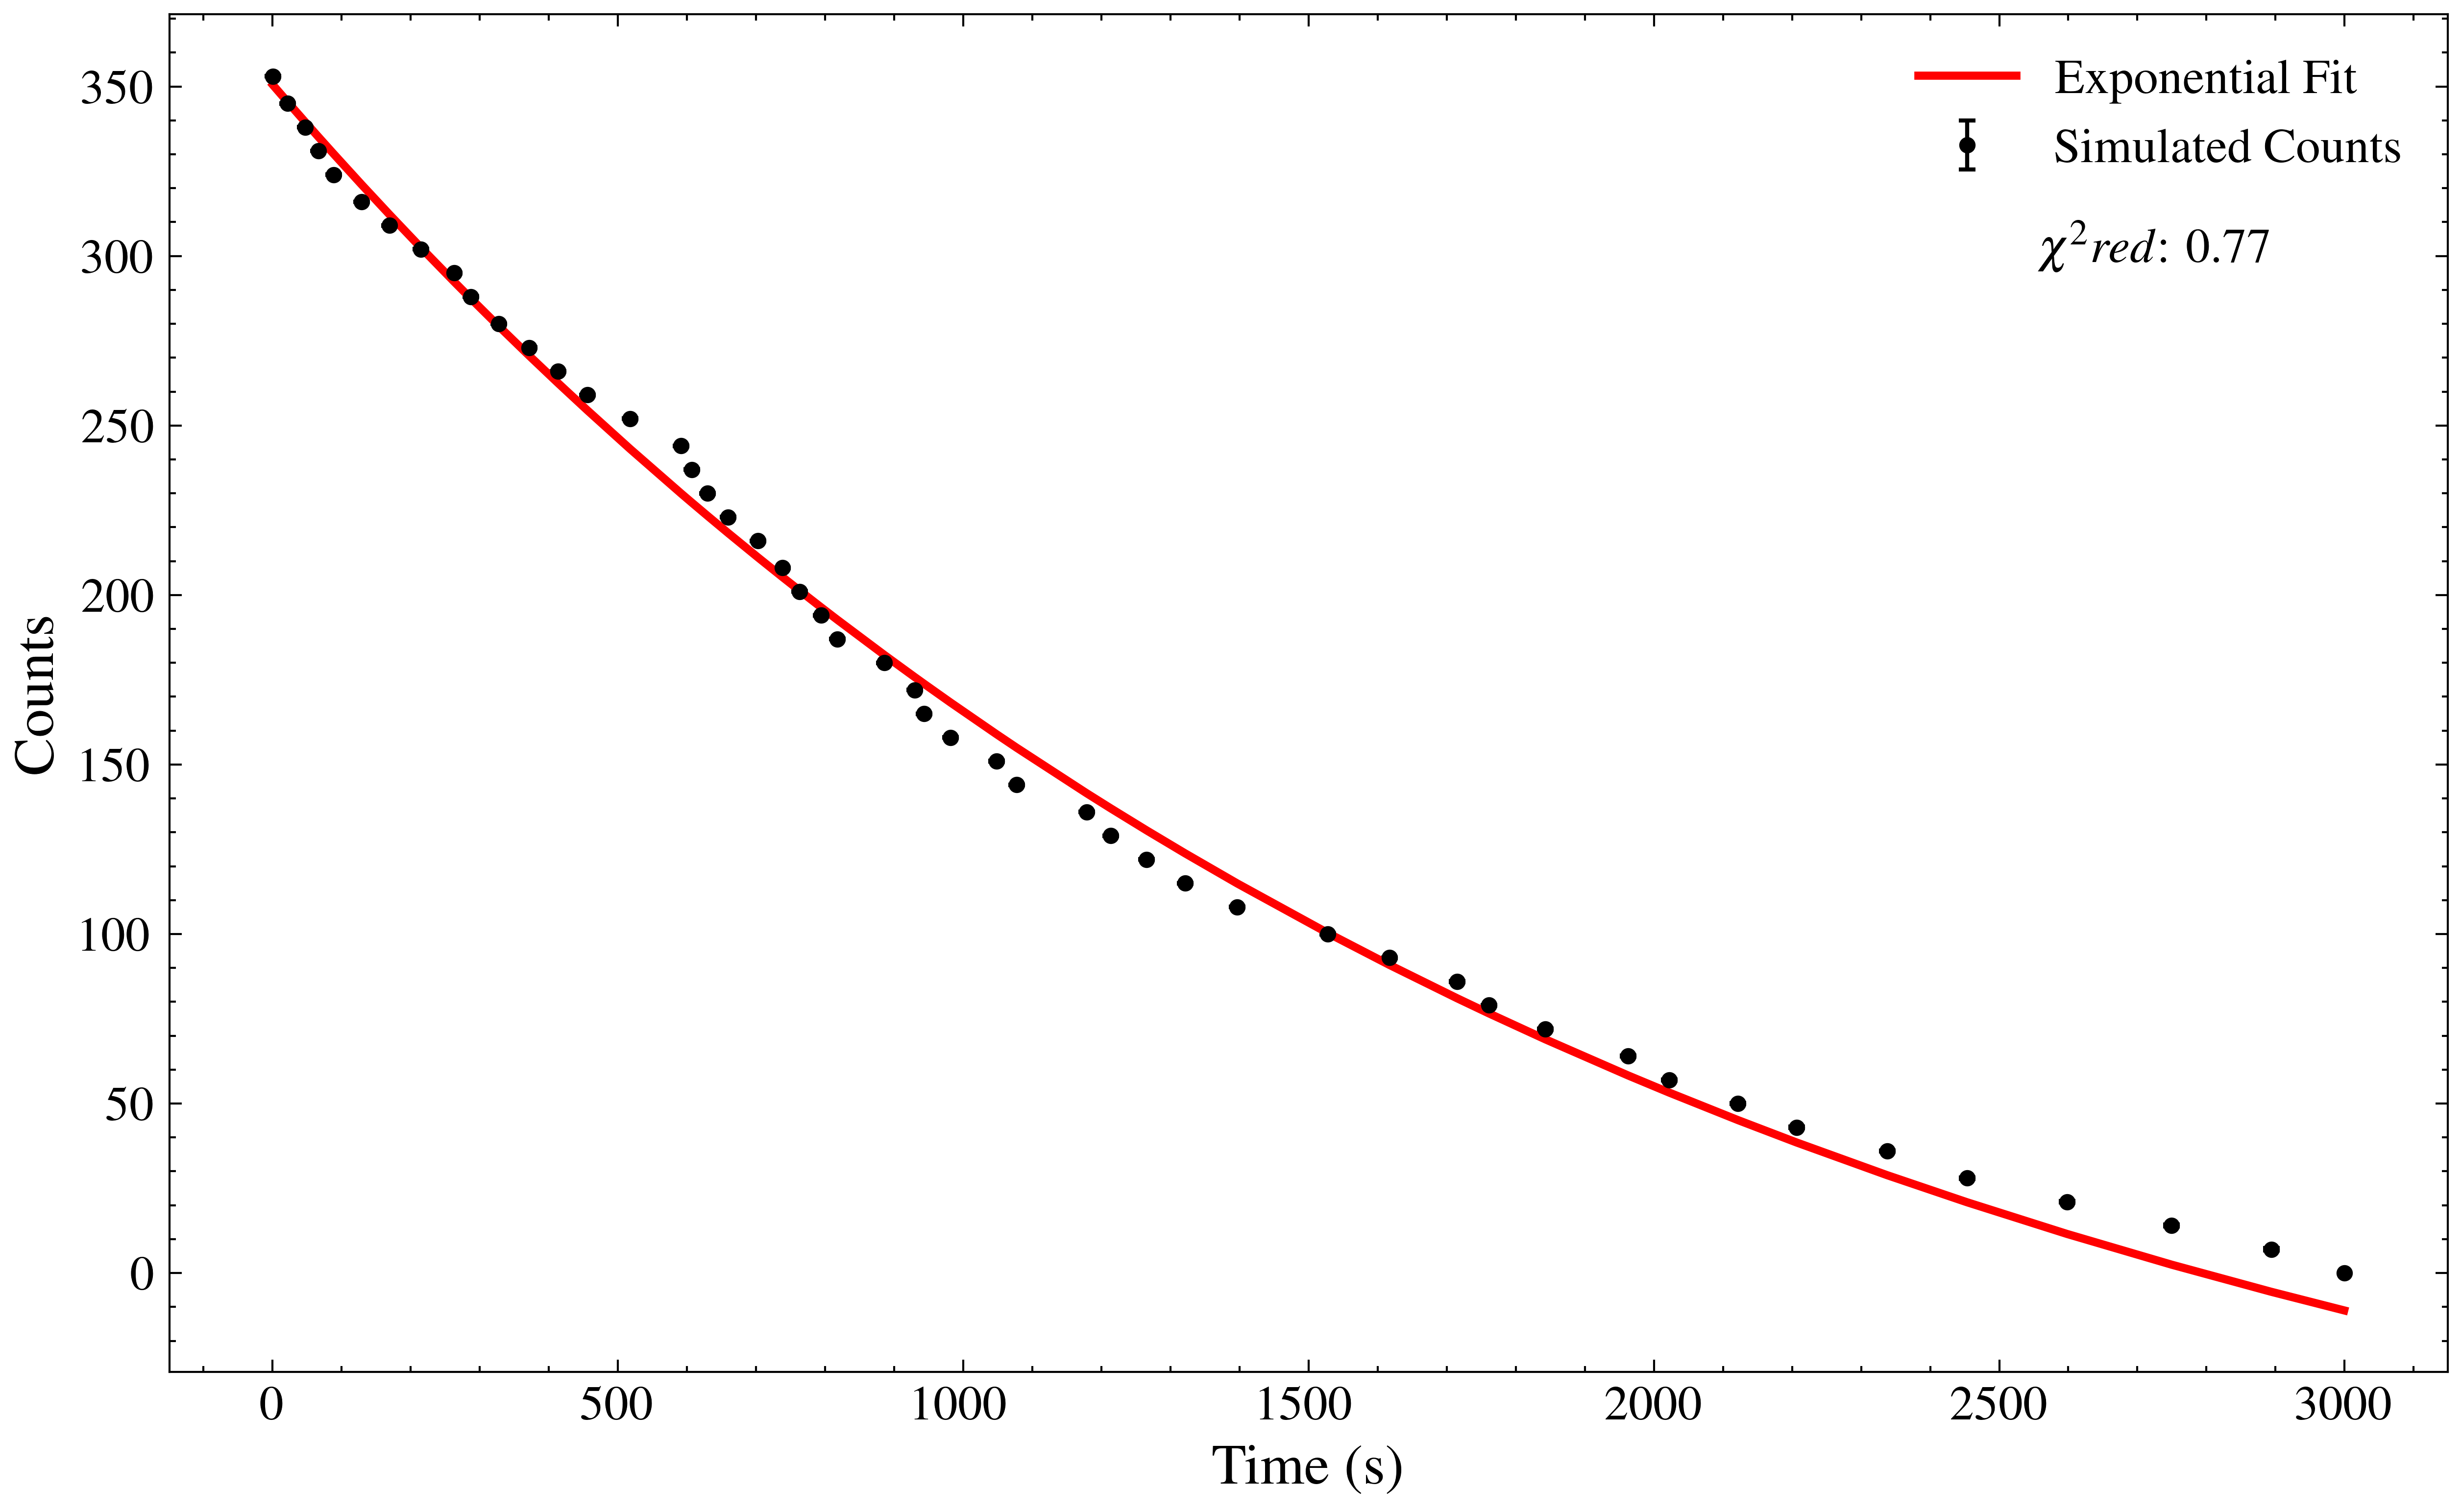

Fitted parameters: a = 460.17548513353347, b = -0.0005140683665117041, c = -109.48909586567395
Covariance matrix: 
[[ 5.53949106e-02  9.37479705e-08 -5.76500229e-02]
 [ 9.37479705e-08  1.69135500e-13 -9.93415941e-08]
 [-5.76500229e-02 -9.93415941e-08  6.04119177e-02]]
Half-life: 22.472600459202535 min


In [ ]:
from scipy.optimize import curve_fit

# Select 50 points in time and coinc_counts
selected_indices = np.linspace(0, len(time) - 1, 50, dtype=int)
selected_time = time[selected_indices]
selected_coinc_counts = coinc_counts[selected_indices]

# Define the exponential function
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Perform the curve fit
params, covariance = curve_fit(exponential, selected_time, selected_coinc_counts, p0=[427, -0.000568, -65],sigma=np.sqrt(selected_coinc_counts), absolute_sigma=True)

# Extract the parameters
a, b, c = params

# Generate fitted data
fitted_data = exponential(selected_time, a, b, c)
# Calculate the chi-squared value
degrees_of_freedom = len(selected_coinc_counts) - len(params)
chi_squared = np.sum(((selected_coinc_counts - fitted_data) ** 2) / fitted_data)
reduced_chi_squared = chi_squared / degrees_of_freedom

# Add chi-squared value to the plot

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.errorbar(selected_time, selected_coinc_counts, label='Simulated Counts', yerr=np.sqrt(selected_coinc_counts), fmt='o', markersize=3, elinewidth=1, capsize=2)
plt.plot(selected_time, fitted_data, color='red', label='Exponential Fit', linewidth=2, linestyle='-')
plt.xlabel('Time (s)', fontsize=14, fontweight='bold')
plt.ylabel('Counts', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.text(0.82, 0.85, f'$\chi^2red$: {reduced_chi_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

# Print the parameters
print(f'Fitted parameters: a = {a}, b = {b}, c = {c}')
print(f'Covariance matrix: \n{covariance}')
print(f'Half-life: {(np.log(2) / -b)/60} min')

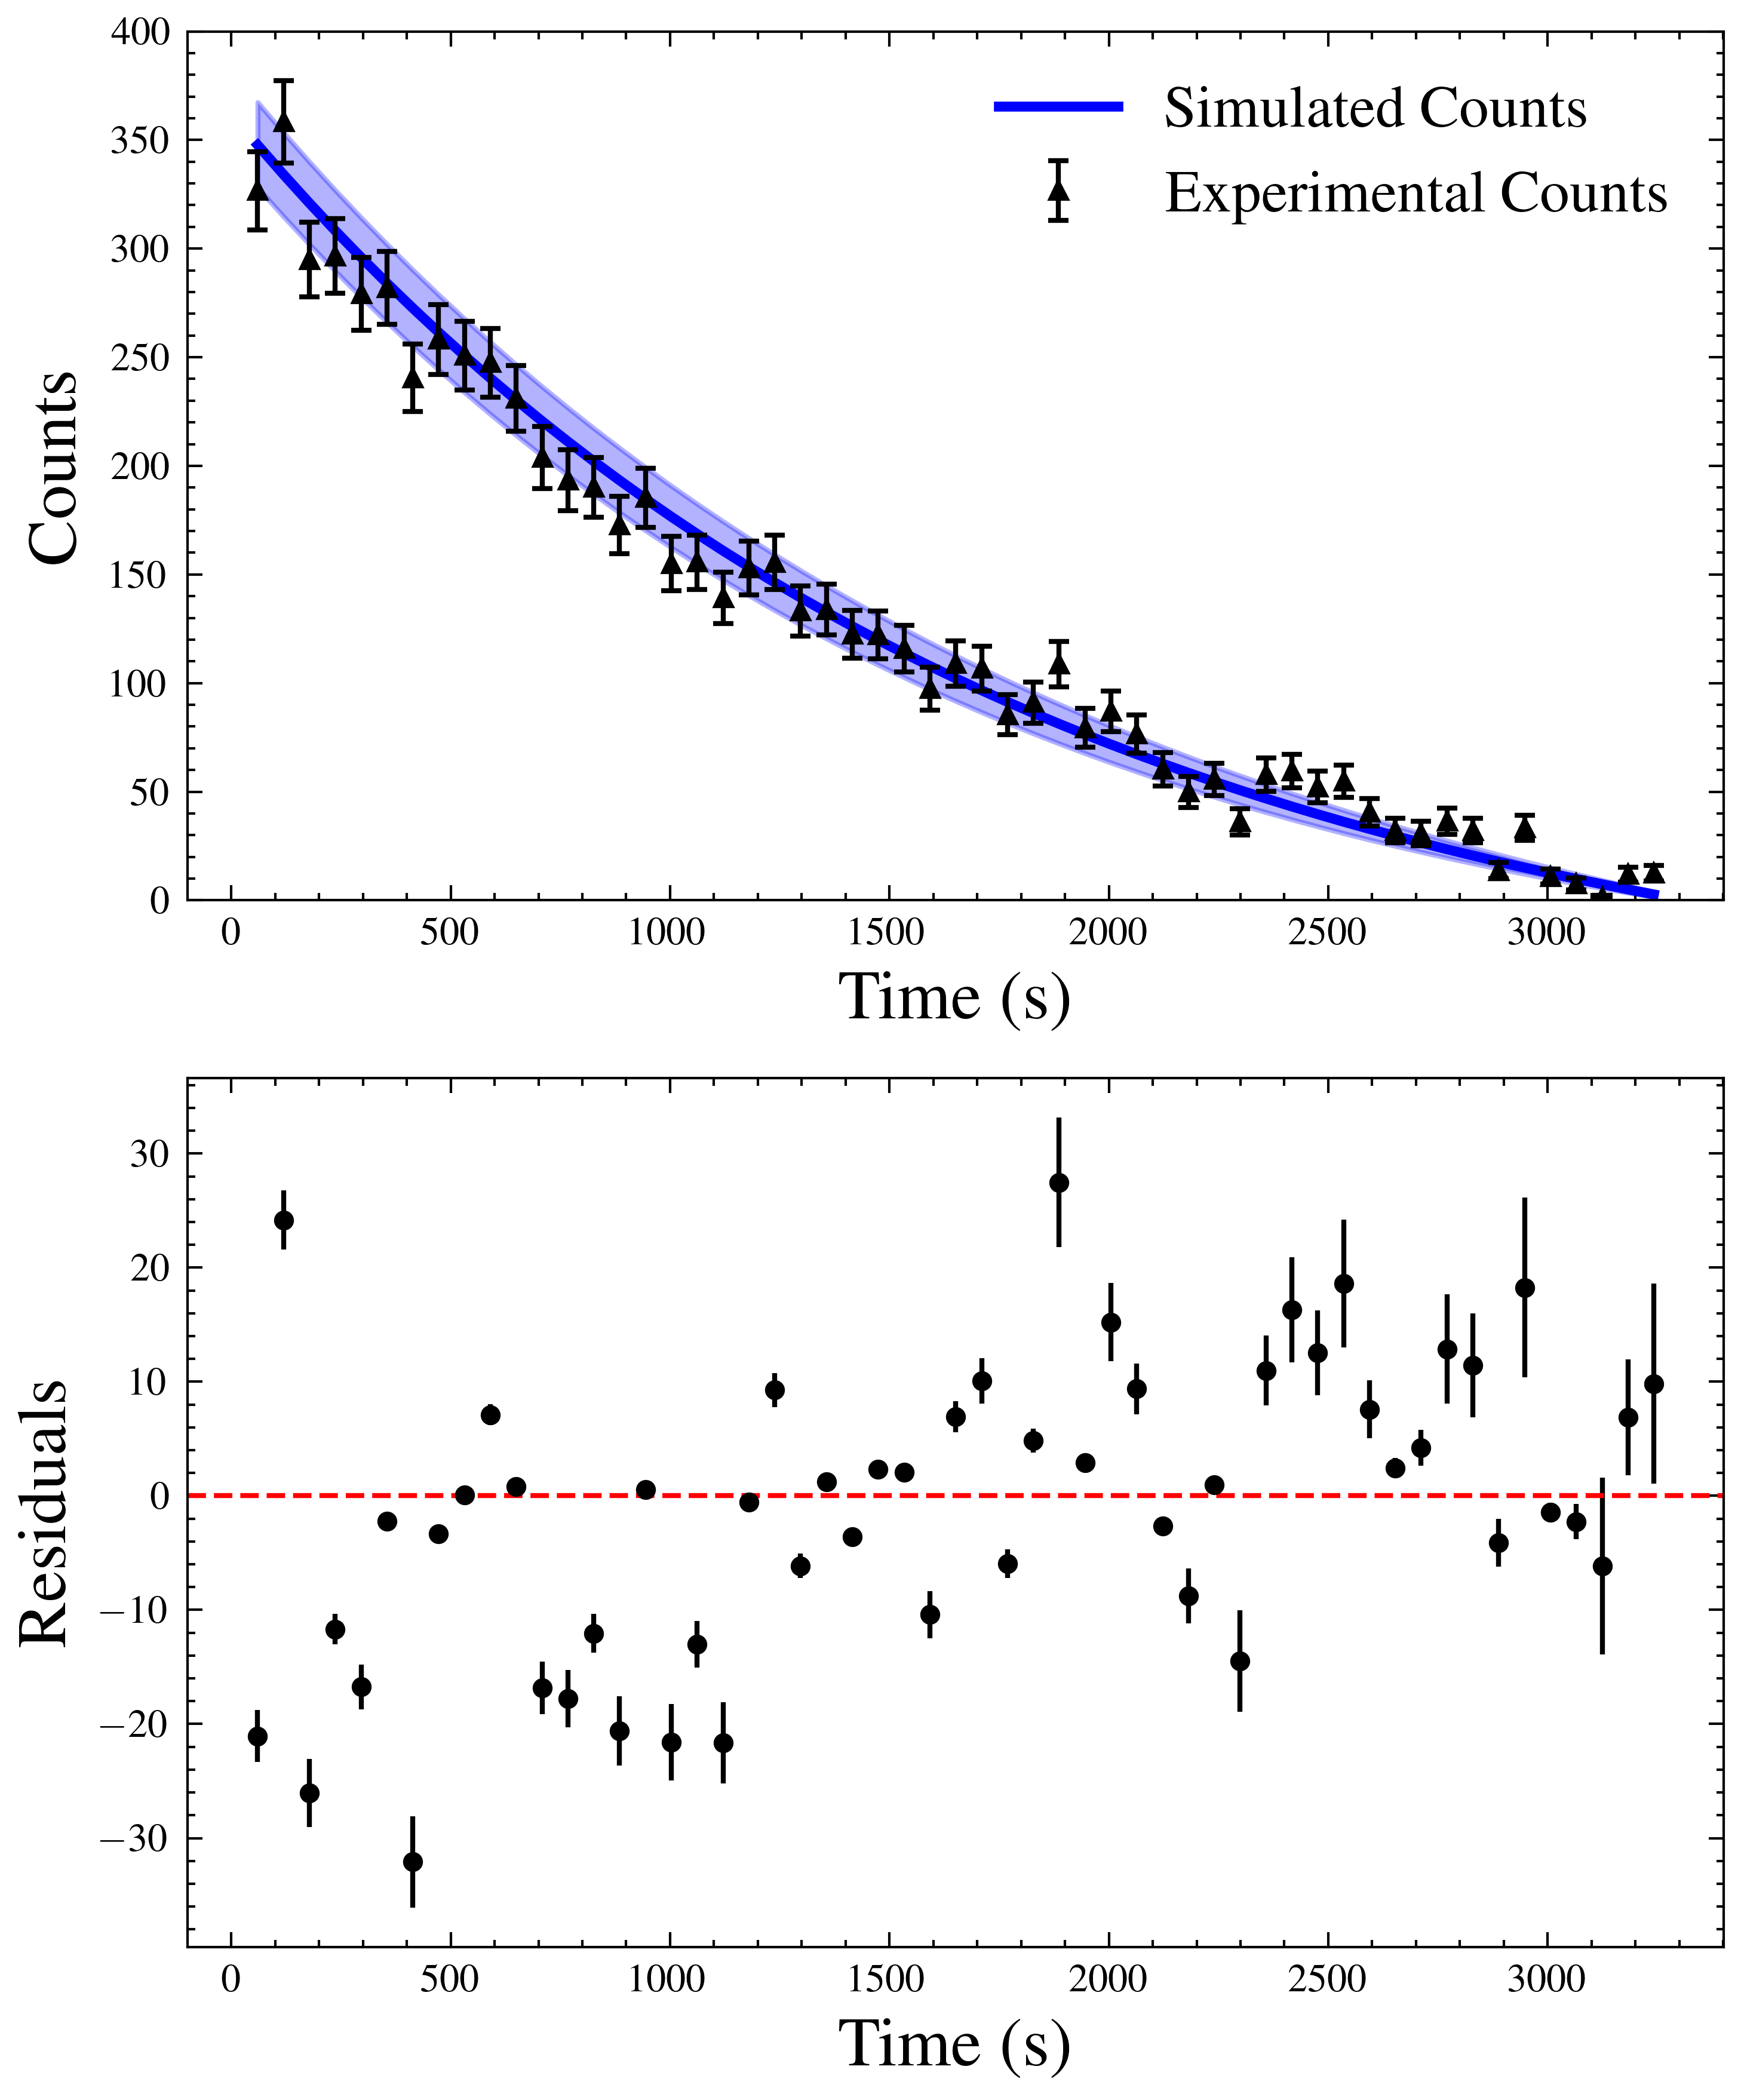

In [ ]:
t_exp = [60.0, 118.92857143, 177.85714286, 236.78571429, 295.71428571,
         354.64285714, 413.57142857, 472.5, 531.42857143, 590.35714286,
         649.28571429, 708.21428571, 767.14285714, 826.07142857, 885.0,
         943.92857143, 1002.85714286, 1061.78571429, 1120.71428571, 1179.64285714,
         1238.57142857, 1297.5, 1356.42857143, 1415.35714286, 1474.28571429,
         1533.21428571, 1592.14285714, 1651.07142857, 1710.0, 1768.92857143,
         1827.85714286, 1886.78571429, 1945.71428571, 2004.64285714, 2063.57142857,
         2122.5, 2181.42857143, 2240.35714286, 2299.28571429, 2358.21428571,
         2417.14285714, 2476.07142857, 2535.0, 2593.92857143, 2652.85714286,
         2711.78571429, 2770.71428571, 2829.64285714, 2888.57142857, 2947.5,
         3006.42857143, 3065.35714286, 3124.28571429, 3183.21428571, 3242.14285714,
         ]
count_exp = [372, 404, 341, 343, 326, 329, 288, 306, 299, 296, 280, 253, 243, 240, 223, 236, 206, 207,
             191, 205, 208, 186, 187, 176, 176, 170, 152, 164, 162, 141, 147, 165, 136, 144, 134, 118,
             108, 114,  95, 117, 119, 112, 115, 101,  93,  92,  98,  94,  76,  96,  74,  71,  65,  76,
              77,  ]


expfit = [373.61970507, 361.85078742, 350.45743025, 339.42764896, 328.74984142,
          318.4127757, 308.40557833, 298.7177228, 289.33901853, 280.25960012,
          271.46991699, 262.96072335, 254.72306843, 246.7482871, 239.02799074,
          231.55405843, 224.31862839, 217.31408973, 210.53307442, 203.96844956,
          197.61330986, 191.4609704, 185.50495958, 179.73901231, 174.15706343,
          168.75324133, 163.52186177, 158.45742189, 153.55459446, 148.80822221,
          144.21331247, 139.76503189, 135.45870136, 131.28979107, 127.25391578,
          123.34683019, 119.56442444, 115.90271987, 112.35786474, 108.92613025,
          105.60390659, 102.38769912, 99.27412475, 96.25990832, 93.34187921,
          90.51696796, 87.78220306, 85.13470783, 82.5716974, 80.09047575,
          77.6884329, 75.36304216, 73.11185747, 70.93251082, 68.82270977,
         ]
t_exp = np.array(t_exp)
count_exp = np.array(count_exp)
expfit=np.array(expfit)
expfit=expfit-58
count_exp=count_exp-45-t_exp*0.006
fit=exponential(t_exp, a, b, c)


#for i in range(len(fit)):
#    fit[i]=fit[i]+np.random.normal(0, 5)

    
#plt.plot(selected_time, fitted_data, label='Exponential Fit', linewidth=2, linestyle='-')
#plt.plot(t_exp, expfit, label='Exponential Fit', linewidth=2, linestyle='-',color='blue')
    
    
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

ax1.plot(t_exp, fit, label='Simulated ', markersize=3, color='blue', linewidth=2)
ax1.fill_between(t_exp, exponential(t_exp, a, b, c) + 20 - t_exp * 0.0058, exponential(t_exp, a, b, c) - 20 + t_exp * 0.0058, color='blue', alpha=.3)
ax1.errorbar(t_exp, count_exp, label='Experimental ', yerr=np.sqrt(count_exp), fmt='^', markersize=3, elinewidth=1, capsize=2, color='black')

ax1.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Counts', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.set_ylim(0, 400)

# Calculate the residuals
residuals = count_exp - fit[:55]

rel_err1 = np.sqrt(count_exp) / count_exp
rel_err2 = np.sqrt(fit) / fit
rel_err = rel_err1 + rel_err2

ax2.errorbar(t_exp, residuals, color='black', yerr=rel_err * np.abs(residuals), fmt='.')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Residuals', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()